<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/Analysis_of_EPI2ME_16S_CSV_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Analysis of EPI2ME 16S CSV Output</h1>

The EPI2ME 16S (and WIMP) analyses allow the download of a summary table of the results. However this table does not contain full lineage information and so it is not immediately useful to create the Sankey tree diagrams that EPI2ME displays in its web interface.

The following short code fragments, demonstrate how to decorate the EPI2ME data table and aggregate the read counts. 

An example 16S report can be found [here](https://epi2me.nanoporetech.com/workflow_instance/242318?token=6FF8C4B6-D055-11EA-A7B7-23477BC332F9).


## Workflow

The following section downloads some necessary pieces of software to decorate the EPI2ME results file with lineage information. There is no need to read through this section if you are not interested in how the code operates. Just skip to the **Data Input** section.

In order to decorate the file with lineage information we will use the [taxonkit](https://bioinf.shenwei.me/taxonkit/) tool. The codebox below will download this tool and also `csvkit` which we will use to convert the EPI2ME file from a comma-separated file to a tab-seperated file (which taxonkit requires)

In [ ]:
analysis_dir = "/epi2melabs/16s_lineage/"
!mkdir -p "$analysis_dir"
%cd "$analysis_dir"
!pip install csvkit
!wget https://github.com/shenwei356/taxonkit/releases/download/v0.6.0/taxonkit_linux_amd64.tar.gz
!tar -xzvf taxonkit_linux_amd64.tar.gz

Taxonkit requires the NCBI taxonomy database to function, let's download and decompress that:

In [ ]:
!mkdir -p "$analysis_dir"/taxdump
%cd "$analysis_dir/taxdump"
!wget http://ftp.ncbi.nih.gov/pub/taxonomy/taxdump.tar.gz
!tar -xzvf taxdump.tar.gz
%cd ..

We now have all we need to get going:
- the EPI2ME results
- taxonkit
- The NCBI taxonomy

Let's first write a code function (that will be used in the **Analysis** section) to read in and perform several conversions on the EPI2ME file:

In [13]:
import pandas as pd
def parse_epi2me(fname):
    dirname = os.path.dirname(fname)
    tsvtmp = os.path.join(dirname, "epi2me2lineage.tsv")
    lintmp = os.path.join(dirname, "epi2me2lineage.lin.tmp")
    fmttmp = os.path.join(dirname, "epi2me2lineage.fmt.tmp")

    print("Converting to TSV")
    !csvformat -T "$fname" > "$tsvtmp"
    print("Running lineage")
    !"$analysis_dir/taxonkit" lineage --data-dir taxdump "$tsvtmp" -i 5 2>/dev/null > "$lintmp"
    print("Running reformat")
    !"$analysis_dir/taxonkit" reformat --data-dir taxdump -i 12 "$lintmp" 2>/dev/null > "$fmttmp"
    print("Munging data")
    epi2me = pd.read_csv(fmttmp, sep='\t')
    # rename some columns so they don't clash with the lineage info
    epi2me.columns = epi2me.columns[0:len(epi2me.columns)-2].to_list() + ['_lineage', 'lineage']
    epi2me = epi2me.rename(columns={'species': 'species_name', 'genus':'genus_name'})
    # extract the lineage info into its on columns in the table
    lineage = epi2me['lineage'].str.split(";", expand=True)
    lineage.columns = ['kingdom', 'phylum', 'class', 'order', 'family','genus', 'species']
    epi2me = pd.concat((epi2me, lineage), axis=1)
    !rm -rf "$tsvtmp" "$lintmp" "$fmttmp"
    return epi2me

## Data Input

To upload your own EPI2ME results file first right-click and select `Upload`:

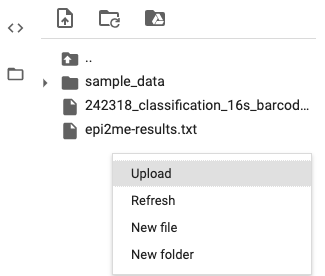

and then right-click on the file an click `Copy path`:

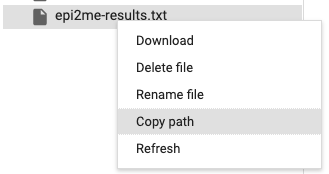

Paste the filepath into the `epi2me_results_file` text box below (remembering to uncheck the `use_sample_data` checkbox).

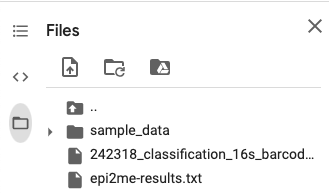

Please select to use the sample data, or enter your own.

In [ ]:
import os
use_sample_data = True #@param {type:"boolean"}
epi2me_results_file = "" #@param {type:"string"}
#@markdown Output file for annotated table:
annotated_output = "/epi2melabs/16s_lineage/epi2me_results_with_lineage.csv" #@param {type:"string"}

if use_sample_data:
    print("Using sample data")
    bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
    domain = "s3-eu-west-1.amazonaws.com"
    site = "https://{}.{}".format(bucket, domain)
    
    fname = "242318_classification_16s_barcode-v1.csv"
    
    !echo "Downloading sample data"
    !wget -q $site/misc/$fname \
        && echo "Download complete" || echo "Download failed"
    !echo
    epi2me_results_file = os.path.abspath(fname)
else:
    print("Using user provided file: {}".format(epi2me_results_file))
if not os.path.isfile(epi2me_results_file):
    print("File does not exist")
print("\nFirst 10 lines of file:")
!head "$epi2me_results_file" || echo "File not readable"

After entering your inputs below, select `Runtime > Run all` from the
menu at the top of the page. If you need to analyse a second file just come back here, change `epi2me_results_file` to a new value and then select `Runtime > Run after`.

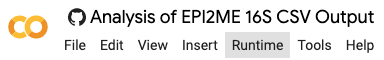

## Analysis

We will first read the input file, annotate it with the lineage information, and write out the annotated table.

In [ ]:
epi2me = parse_epi2me(epi2me_results_file)
epi2me.to_csv(annotated_output)
print("Annotated data table written to: {}. Download from the filebrowser.".format(annotated_output))

The output table is the same as the input EPI2ME results file with additional columns indicating the taxonomic ranks to with each read has been assigned. For example, here is the start of the table:

In [ ]:
display(epi2me.head())

With this data table we can now extract counts of reads at any of the taxonomic ranks, for example:

In [ ]:
#@markdown **Aggregate counts by rank**

#@markdown Select a rank to aggregate read counts and then click the `Play` button
#@markdown to the left-hand side.
aggregation_rank = "kingdom" #@param ['kingdom', 'phylum', 'class', 'order', 'family','genus', 'species']

results = (
    epi2me[aggregation_rank]
    .value_counts()
    .reset_index()
    .rename(columns={'index':aggregation_rank, aggregation_rank:'count'}))
display(results.head())
output = 'aggregated_counts_by_{}.csv'.format(aggregation_rank)
results.to_csv(output)
print("Results written to {}, download from the filebrowser.".format(output))


### Some notes

The EPI2ME table provides a `taxid`, `species_taxid` and a `genus_taxid`. EPI2ME provides some sanity checking on its classification. If the top hits of a read are from different genera the `taxid` will be empty, that is to say the read is "Unclassified". The code above is using the value of the `taxid` field to derive the lineage information.